# Di Tella 2017
This file replicates the results from [Di Tella 2017, Uncertainty Shocks and Balance Sheet Recessions](https://gsb-faculty.stanford.edu/sebastian-di-tella/files/2022/10/DiTella_Unc_Shocks_2556027.pdf)

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModelTimeStep
from deep_macrofin import ActivationType, OptimizerType, SamplingMethod, plot_loss_df, set_seeds

In [2]:
latex_var_mapping = {
    # variables
    r"\iota": "iota",
    r"\hat{e}": "e_hat",
    r"\hat{c}": "c_hat",
    r"\sigma_{x,1}": "sigxtop",
    r"\sigma_{x,2}": "sigxbot",
    r"\sigma_x": "sigx",
    r"\sigma_p": "sigp",
    r"\sigma_\xi": "sigxi",
    r"\sigma_\zeta": "sigzeta",
    r"\tilde{\sigma_n}": "signtilde",
    r"\sigma_n": "sign",
    r"\pi": "signxi",
    r"\sigma_w": "sigw",
    r"\mu_n": "mun",
    r"\mu_x": "mux",
    r"\mu_p": "mup",
    r"\mu_\xi": "muxi",
    r"\mu_\zeta": "muzeta",
    r"\mu_w": "muw",

    # agents
    r"\xi": "xi",
    r"\zeta": "zeta",

    # constants
    r"\bar{\sigma_v}": "sigv_mean",
    r"\sigma_v": "sigv",
    r"\mu_v": "muv",
    r"\sigma": "sigma",
    r"\lambda": "lbd",
    r"\bar{v}": "v_mean",
    r"\rho": "rho",
    r"\gamma": "gamma",
    r"\psi": "psi",
    r"\tau": "tau",
    r"\delta": "delta",
    r"\phi": "phi",
}

In [3]:
set_seeds(0)
pde_model = PDEModelTimeStep("ditella", 
                     {"batch_size": 20, "num_outer_iterations": 50, "num_inner_iterations": 5000}, 
                     latex_var_mapping)
pde_model.set_state(["x", "v"], {"x": [0.05, 0.95], "v": [0.05, 0.95]})
pde_model.add_agents(["xi", "zeta"], 
                     {"xi": {
                         "positive": True, 
                        }, 
                      "zeta": {
                          "positive": True, 
                          }
                     })
pde_model.add_endogs(["p", "r"], 
                     {"p": {
                         "positive": True, 
                         },
                     })
pde_model.add_params({
    "a": 1,
    "sigma": 0.0125,
    "lbd": 1.38,
    "v_mean": 0.25,
    "sigv_mean": -0.17,
    "rho": 0.0665,
    "gamma": 5,
    "psi": 0.5,
    "tau": 1.15,
    "phi": 0.2,

    "A": 53.2,
    "B": -0.8668571428571438,
    "delta": 0.05,
})
pde_model.add_equation(r"$g &= \frac{1}{2*A} * (p - B) - \delta$") # g &= \frac{1}{2*A} * (p - B) - \delta
pde_model.add_equation(r"$\iota &= A * (g+\delta)^2 + B * (g+\delta)$") # \iota &= A * (g+\delta)^2 + B * (g+\delta)
pde_model.add_equation(r"$\mu_v &= \lambda * (\bar{v} - v)$")
pde_model.add_equation(r"$\sigma_v &= \bar{\sigma_v} * \sqrt{v}$")
pde_model.add_equation(r"$\hat{e} &= \rho^{1/\psi} * \xi^{(\psi-1)/\psi}$")
pde_model.add_equation(r"$\hat{c} &= \rho^{1/\psi} * \zeta^{(\psi-1)/\psi}$")
pde_model.add_equation(r"$\sigma_{x,1} &= (1-x) * x * \frac{1-\gamma}{\gamma} * \left( \frac{1}{\xi} * \frac{\partial \xi}{\partial v} - \frac{1}{\zeta} * \frac{\partial \zeta}{\partial v} \right)$")
pde_model.add_equation(r"$\sigma_{x,2} &= 1 - (1-x) * x * \frac{1-\gamma}{\gamma} * \left( \frac{1}{\xi} * \frac{\partial \xi}{\partial x} - \frac{1}{\zeta} * \frac{\partial \zeta}{\partial x} \right)$")
pde_model.add_equation(r"$\sigma_x &= \frac{\sigma_{x,1}}{\sigma_{x,2}} * \sigma_v$")
pde_model.add_equation(r"$\sigma_p &= \frac{1}{p} * \left( \frac{\partial p}{\partial v} * \sigma_v + \frac{\partial p}{\partial x} * \sigma_x \right)$")
pde_model.add_equation(r"$\sigma_\xi &= \frac{1}{\xi} * \left( \frac{\partial \xi}{\partial v} * \sigma_v + \frac{\partial \xi}{\partial x} * \sigma_x \right)$")
pde_model.add_equation(r"$\sigma_\zeta &= \frac{1}{\zeta} * \left( \frac{\partial \zeta}{\partial v} * \sigma_v + \frac{\partial \zeta}{\partial x} * \sigma_x \right)$")
pde_model.add_equation(r"$\sigma_n &= \sigma + \sigma_p + \frac{\sigma_x}{x}$")
pde_model.add_equation(r"$\pi &= \gamma * \sigma_n + (\gamma-1) * \sigma_\xi$")
pde_model.add_equation(r"$\sigma_w &= \frac{\pi}{\gamma} - \frac{\gamma-1}{\gamma} *  \sigma_\zeta$")
pde_model.add_equation(r"$\mu_w &= r + \pi * \sigma_w$")
pde_model.add_equation(r"$\mu_n &= r + \frac{\gamma}{x^2} * (\phi * v)^2 + \pi * \sigma_n$")
pde_model.add_equation(r"$\tilde{\sigma_n} &= \frac{\phi}{x} * v$")
pde_model.add_equation(r"$\mu_x &= x * \left(\mu_n - \hat{e} - \tau + \frac{a-\iota}{p} - r - \pi * (\sigma+\sigma_p) - \frac{\gamma}{x} * (\phi * v)^2 + (\sigma + \sigma_p)^2 - \sigma_n * (\sigma + \sigma_p)\right)$")
pde_model.add_equation(r"$\mu_p &= \frac{1}{p} * \left( \mu_v * \frac{\partial p}{\partial v} + \mu_x * \frac{\partial p}{\partial x} + \frac{1}{2} * \left( \sigma_v^2 * \frac{\partial^2 p}{\partial v^2} + 2 * \sigma_v * \sigma_x * \frac{\partial^2 p}{\partial v \partial x} + \sigma_x^2 * \frac{\partial^2 p}{\partial x^2} \right)\right)$")
pde_model.add_equation(r"$\mu_\xi &= \frac{\rho}{1-\psi} - \frac{\hat{e}^{1-\psi}}{1-\psi} * \rho * \xi^{\psi-1} - \frac{\tau}{1-\gamma} * \left(\left(\frac{\zeta}{\xi} \right)^{1-\gamma}-1 \right) - \mu_n + \hat{e} + \frac{\gamma}{2} * \left( \sigma_n^2 + \sigma_\xi^2 - 2 * \frac{1-\gamma}{\gamma} * \sigma_n * \sigma_\xi + \tilde{\sigma_n}^2 \right)$")
pde_model.add_equation(r"$\mu_\zeta &= \frac{\rho}{1-\psi} - \frac{\hat{c}^{1-\psi}}{1-\psi} * \rho * \zeta^{\psi-1} - \mu_w + \hat{c} + \frac{\gamma}{2} * \left( \sigma_w^2 + \sigma_\zeta^2 - 2 * \frac{1-\gamma}{\gamma} * \sigma_w * \sigma_\zeta \right)$")

pde_model.add_endog_equation(r"$a - \iota &= p * (\hat{e} * x + \hat{c} * (1-x))$")
pde_model.add_endog_equation(r"$\sigma + \sigma_p &= \sigma_n * x + \sigma_w * (1-x)$")
pde_model.add_endog_equation(r"$\frac{a-\iota}{p} + g + \mu_p + \sigma * \sigma_p - r &= (\sigma + \sigma_p) * \pi + \gamma * \frac{1}{x} * (\phi * v)^2$")

pde_model.add_hjb_equation(r"$\frac{\partial \xi}{\partial t} + \mu_v * \frac{\partial \xi}{\partial v} + \mu_x * \frac{\partial \xi}{\partial x} + \frac{1}{2} * \left( \sigma_v^2 * \frac{\partial^2 \xi}{\partial v^2} + 2 * \sigma_v * \sigma_x * \frac{\partial^2 \xi}{\partial v \partial x} + \sigma_x^2 * \frac{\partial^2 \xi}{\partial x^2} \right) - \mu_\xi * \xi$")
pde_model.add_hjb_equation(r"$\frac{\partial \zeta}{\partial t} + \mu_v * \frac{\partial \zeta}{\partial v} + \mu_x * \frac{\partial \zeta}{\partial x} + \frac{1}{2} * \left( \sigma_v^2 * \frac{\partial^2 \zeta}{\partial v^2} + 2 * \sigma_v * \sigma_x * \frac{\partial^2 \zeta}{\partial v \partial x} + \sigma_x^2 * \frac{\partial^2 \zeta}{\partial x^2}\right) - \mu_\zeta * \zeta$")
print(pde_model)
if not os.path.exists("./models/ditella/model.pt"):
    pde_model.train_model("./models/ditella", "model.pt", True)
    pde_model.load_model(torch.load("./models/ditella/model_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/ditella/model_best.pt"))
    pde_model.eval_model(True)

============================Summary of Model ditella============================
Config: {
 "batch_size": 20,
 "num_outer_iterations": 50,
 "num_inner_iterations": 5000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "min_t": 0.0,
 "max_t": 1.0,
 "outer_loop_convergence_thres": 0.0001
}
Latex Variable Mapping:
{
 "\\iota": "iota",
 "\\hat{e}": "e_hat",
 "\\hat{c}": "c_hat",
 "\\sigma_{x,1}": "sigxtop",
 "\\sigma_{x,2}": "sigxbot",
 "\\sigma_x": "sigx",
 "\\sigma_p": "sigp",
 "\\sigma_\\xi": "sigxi",
 "\\sigma_\\zeta": "sigzeta",
 "\\tilde{\\sigma_n}": "signtilde",
 "\\sigma_n": "sign",
 "\\pi": "signxi",
 "\\sigma_w": "sigw",
 "\\mu_n": "mun",
 "\\mu_x": "mux",
 "\\mu_p": "mup",
 "\\mu_\\xi": "muxi",
 "\\mu_\\zeta": "muzeta",
 "\\mu_w": "muw",
 "\\xi": "xi",
 "\\zeta": "zeta",
 "\\bar{\\sigma_v}": "sigv_mean",
 "\\sigma_v": "sigv",
 "\\mu_v": "muv",
 "\\sigma": "sigma",
 "\\lambda": "lbd",
 "\\bar{v}": "v_mean",
 "\\rho": "rho",
 "\\gamma": "gamma",
 "\\psi": "psi

Total loss: 0.9992: 100%|██████████| 5000/5000 [10:54<00:00,  7.64it/s]
D:\Research\continuous-time-eco-models\deep_macrofin\pde_model_time_step.py:322: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Model loaded
xi: Absolute Change: 0.99365, Relative Change:  0.99365
zeta: Absolute Change: 0.14911, Relative Change:  0.14911
p: Absolute Change: 1.69453, Relative Change:  1.69453
r: Absolute Change: 0.86199, Relative Change:  0.86199
Outer Loop 0 Finished in 654.2988s. Loading best model...


Total loss: 0.0002: 100%|██████████| 3535/3535 [07:42<00:00,  7.65it/s]


Model loaded
xi: Absolute Change: 0.00161, Relative Change:  0.24978
zeta: Absolute Change: 0.21680, Relative Change:  0.18933
p: Absolute Change: 0.62608, Relative Change:  0.23255
r: Absolute Change: 0.06111, Relative Change:  6.03229
Outer Loop 1 Finished in 462.2430s. Loading best model...


Total loss: 0.0001: 100%|██████████| 2886/2886 [06:10<00:00,  7.80it/s]


Model loaded
xi: Absolute Change: 0.00068, Relative Change:  0.07846
zeta: Absolute Change: 0.16446, Relative Change:  0.17567
p: Absolute Change: 0.22739, Relative Change:  0.06796
r: Absolute Change: 0.03203, Relative Change:  0.42890
Outer Loop 2 Finished in 370.1681s. Loading best model...


Total loss: 0.0001: 100%|██████████| 2500/2500 [05:30<00:00,  7.57it/s]


Model loaded
xi: Absolute Change: 0.00014, Relative Change:  0.01308
zeta: Absolute Change: 0.11944, Relative Change:  0.15552
p: Absolute Change: 0.03742, Relative Change:  0.01026
r: Absolute Change: 0.01790, Relative Change:  0.42954
Outer Loop 3 Finished in 330.4577s. Loading best model...


Total loss: 0.0001: 100%|██████████| 2236/2236 [05:02<00:00,  7.40it/s]


Model loaded
xi: Absolute Change: 0.00023, Relative Change:  0.03141
zeta: Absolute Change: 0.09469, Relative Change:  0.14632
p: Absolute Change: 0.10460, Relative Change:  0.02985
r: Absolute Change: 0.01381, Relative Change:  0.38918
Outer Loop 4 Finished in 302.3266s. Loading best model...


Total loss: 0.0001: 100%|██████████| 2041/2041 [04:21<00:00,  7.81it/s]


Model loaded
xi: Absolute Change: 0.00044, Relative Change:  0.05689
zeta: Absolute Change: 0.07956, Relative Change:  0.14416
p: Absolute Change: 0.18079, Relative Change:  0.05276
r: Absolute Change: 0.01219, Relative Change:  0.28064
Outer Loop 5 Finished in 261.4886s. Loading best model...


Total loss: 0.0001: 100%|██████████| 1889/1889 [04:08<00:00,  7.60it/s]


Model loaded
xi: Absolute Change: 0.00058, Relative Change:  0.07693
zeta: Absolute Change: 0.06768, Relative Change:  0.14341
p: Absolute Change: 0.23235, Relative Change:  0.07136
r: Absolute Change: 0.01054, Relative Change:  0.24637
Outer Loop 6 Finished in 248.6007s. Loading best model...


Total loss: 0.0001: 100%|██████████| 1767/1767 [03:46<00:00,  7.81it/s]


Model loaded
xi: Absolute Change: 0.00066, Relative Change:  0.09267
zeta: Absolute Change: 0.05719, Relative Change:  0.14164
p: Absolute Change: 0.26282, Relative Change:  0.08670
r: Absolute Change: 0.00852, Relative Change:  0.25230
Outer Loop 7 Finished in 226.2566s. Loading best model...


Total loss: 0.0001: 100%|██████████| 1666/1666 [03:38<00:00,  7.63it/s]


Model loaded
xi: Absolute Change: 0.00070, Relative Change:  0.10683
zeta: Absolute Change: 0.04774, Relative Change:  0.13790
p: Absolute Change: 0.27971, Relative Change:  0.10082
r: Absolute Change: 0.00778, Relative Change:  0.48601
Outer Loop 8 Finished in 218.4017s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1581/1581 [03:17<00:00,  8.00it/s]


Model loaded
xi: Absolute Change: 0.00066, Relative Change:  0.11134
zeta: Absolute Change: 0.03944, Relative Change:  0.13230
p: Absolute Change: 0.26571, Relative Change:  0.10629
r: Absolute Change: 0.01111, Relative Change:  0.70147
Outer Loop 9 Finished in 197.6611s. Loading best model...


Total loss: 0.0003: 100%|██████████| 1507/1507 [03:08<00:00,  7.99it/s]


Model loaded
xi: Absolute Change: 0.00059, Relative Change:  0.11026
zeta: Absolute Change: 0.03239, Relative Change:  0.12532
p: Absolute Change: 0.23779, Relative Change:  0.10622
r: Absolute Change: 0.01728, Relative Change:  2.62440
Outer Loop 10 Finished in 188.5916s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1443/1443 [03:02<00:00,  7.89it/s]


Model loaded
xi: Absolute Change: 0.00050, Relative Change:  0.10373
zeta: Absolute Change: 0.02654, Relative Change:  0.11747
p: Absolute Change: 0.20191, Relative Change:  0.10071
r: Absolute Change: 0.02273, Relative Change:  2.41356
Outer Loop 11 Finished in 182.9960s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1386/1386 [03:08<00:00,  7.36it/s]


Model loaded
xi: Absolute Change: 0.00039, Relative Change:  0.09036
zeta: Absolute Change: 0.02171, Relative Change:  0.10898
p: Absolute Change: 0.15970, Relative Change:  0.08835
r: Absolute Change: 0.02724, Relative Change:  0.74172
Outer Loop 12 Finished in 188.3969s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1336/1336 [02:54<00:00,  7.65it/s]


Model loaded
xi: Absolute Change: 0.00029, Relative Change:  0.07087
zeta: Absolute Change: 0.01773, Relative Change:  0.09993
p: Absolute Change: 0.11584, Relative Change:  0.07001
r: Absolute Change: 0.03043, Relative Change:  1.66320
Outer Loop 13 Finished in 174.6685s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1290/1290 [02:38<00:00,  8.13it/s]


Model loaded
xi: Absolute Change: 0.00024, Relative Change:  0.06414
zeta: Absolute Change: 0.01452, Relative Change:  0.09101
p: Absolute Change: 0.09781, Relative Change:  0.06350
r: Absolute Change: 0.03119, Relative Change:  0.60246
Outer Loop 14 Finished in 158.6402s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1250/1250 [02:52<00:00,  7.27it/s]


Model loaded
xi: Absolute Change: 0.00020, Relative Change:  0.05624
zeta: Absolute Change: 0.01196, Relative Change:  0.08250
p: Absolute Change: 0.08084, Relative Change:  0.05592
r: Absolute Change: 0.03213, Relative Change:  0.59711
Outer Loop 15 Finished in 172.0132s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1212/1212 [02:45<00:00,  7.31it/s]


Model loaded
xi: Absolute Change: 0.00017, Relative Change:  0.04853
zeta: Absolute Change: 0.00983, Relative Change:  0.07400
p: Absolute Change: 0.06611, Relative Change:  0.04835
r: Absolute Change: 0.03189, Relative Change:  0.44828
Outer Loop 16 Finished in 165.7086s. Loading best model...


Total loss: 0.0001: 100%|██████████| 1178/1178 [02:26<00:00,  8.05it/s]


Model loaded
xi: Absolute Change: 0.00013, Relative Change:  0.04116
zeta: Absolute Change: 0.00808, Relative Change:  0.06574
p: Absolute Change: 0.05384, Relative Change:  0.04128
r: Absolute Change: 0.03092, Relative Change:  0.19949
Outer Loop 17 Finished in 146.3766s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1147/1147 [02:38<00:00,  7.22it/s]


Model loaded
xi: Absolute Change: 0.00011, Relative Change:  0.03568
zeta: Absolute Change: 0.00667, Relative Change:  0.05812
p: Absolute Change: 0.04480, Relative Change:  0.03577
r: Absolute Change: 0.02971, Relative Change:  1.43226
Outer Loop 18 Finished in 158.7704s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1118/1118 [02:29<00:00,  7.46it/s]


Model loaded
xi: Absolute Change: 0.00008, Relative Change:  0.02681
zeta: Absolute Change: 0.00554, Relative Change:  0.05134
p: Absolute Change: 0.03292, Relative Change:  0.02714
r: Absolute Change: 0.02671, Relative Change:  0.11829
Outer Loop 19 Finished in 149.7939s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1091/1091 [02:15<00:00,  8.06it/s]


Model loaded
xi: Absolute Change: 0.00005, Relative Change:  0.01592
zeta: Absolute Change: 0.00463, Relative Change:  0.04520
p: Absolute Change: 0.01994, Relative Change:  0.01666
r: Absolute Change: 0.02398, Relative Change:  0.08771
Outer Loop 20 Finished in 135.3429s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1066/1066 [02:36<00:00,  6.82it/s]


Model loaded
xi: Absolute Change: 0.00005, Relative Change:  0.01641
zeta: Absolute Change: 0.00387, Relative Change:  0.03962
p: Absolute Change: 0.01978, Relative Change:  0.01691
r: Absolute Change: 0.02170, Relative Change:  0.07230
Outer Loop 21 Finished in 156.2794s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1042/1042 [02:09<00:00,  8.07it/s]


Model loaded
xi: Absolute Change: 0.00004, Relative Change:  0.01446
zeta: Absolute Change: 0.00328, Relative Change:  0.03501
p: Absolute Change: 0.01718, Relative Change:  0.01495
r: Absolute Change: 0.01925, Relative Change:  0.05892
Outer Loop 22 Finished in 129.0765s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1020/1020 [02:20<00:00,  7.26it/s]


Model loaded
xi: Absolute Change: 0.00004, Relative Change:  0.01392
zeta: Absolute Change: 0.00278, Relative Change:  0.03072
p: Absolute Change: 0.01613, Relative Change:  0.01428
r: Absolute Change: 0.01797, Relative Change:  0.05539
Outer Loop 23 Finished in 140.4890s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1000/1000 [02:09<00:00,  7.70it/s]


Model loaded
xi: Absolute Change: 0.00004, Relative Change:  0.01354
zeta: Absolute Change: 0.00236, Relative Change:  0.02698
p: Absolute Change: 0.01536, Relative Change:  0.01383
r: Absolute Change: 0.01669, Relative Change:  0.05225
Outer Loop 24 Finished in 129.8447s. Loading best model...


Total loss: 0.0000: 100%|██████████| 980/980 [02:05<00:00,  7.79it/s]


Model loaded
xi: Absolute Change: 0.00004, Relative Change:  0.01319
zeta: Absolute Change: 0.00200, Relative Change:  0.02346
p: Absolute Change: 0.01464, Relative Change:  0.01339
r: Absolute Change: 0.01550, Relative Change:  0.04267
Outer Loop 25 Finished in 125.7277s. Loading best model...


Total loss: 0.0000: 100%|██████████| 962/962 [02:08<00:00,  7.47it/s]


Model loaded
xi: Absolute Change: 0.00002, Relative Change:  0.00748
zeta: Absolute Change: 0.00170, Relative Change:  0.02051
p: Absolute Change: 0.00864, Relative Change:  0.00786
r: Absolute Change: 0.01419, Relative Change:  0.03705
Outer Loop 26 Finished in 128.8194s. Loading best model...


Total loss: 0.0000: 100%|██████████| 944/944 [02:07<00:00,  7.41it/s]


Model loaded
xi: Absolute Change: 0.00003, Relative Change:  0.00947
zeta: Absolute Change: 0.00141, Relative Change:  0.01737
p: Absolute Change: 0.01038, Relative Change:  0.00967
r: Absolute Change: 0.01284, Relative Change:  0.03243
Outer Loop 27 Finished in 127.4171s. Loading best model...


Total loss: 0.0000: 100%|██████████| 928/928 [02:06<00:00,  7.32it/s]


Model loaded
xi: Absolute Change: 0.00002, Relative Change:  0.00480
zeta: Absolute Change: 0.00121, Relative Change:  0.01521
p: Absolute Change: 0.00554, Relative Change:  0.00506
r: Absolute Change: 0.01221, Relative Change:  0.02966
Outer Loop 28 Finished in 126.7038s. Loading best model...


Total loss: 0.0000: 100%|██████████| 912/912 [01:58<00:00,  7.71it/s]


Model loaded
xi: Absolute Change: 0.00001, Relative Change:  0.00331
zeta: Absolute Change: 0.00100, Relative Change:  0.01285
p: Absolute Change: 0.00363, Relative Change:  0.00330
r: Absolute Change: 0.01031, Relative Change:  0.02565
Outer Loop 29 Finished in 118.2286s. Loading best model...


Total loss: 0.0000: 100%|██████████| 898/898 [02:05<00:00,  7.18it/s]


Model loaded
xi: Absolute Change: 0.00001, Relative Change:  0.00271
zeta: Absolute Change: 0.00082, Relative Change:  0.01069
p: Absolute Change: 0.00252, Relative Change:  0.00244
r: Absolute Change: 0.00915, Relative Change:  0.02366
Outer Loop 30 Finished in 125.0548s. Loading best model...


Total loss: 0.0000: 100%|██████████| 883/883 [01:46<00:00,  8.29it/s]


Model loaded
xi: Absolute Change: 0.00000, Relative Change:  0.00304
zeta: Absolute Change: 0.00065, Relative Change:  0.00861
p: Absolute Change: 0.00249, Relative Change:  0.00260
r: Absolute Change: 0.00699, Relative Change:  0.03296
Outer Loop 31 Finished in 106.5632s. Loading best model...


Total loss: 0.0000: 100%|██████████| 870/870 [01:55<00:00,  7.54it/s]


Model loaded
xi: Absolute Change: 0.00001, Relative Change:  0.00636
zeta: Absolute Change: 0.00054, Relative Change:  0.00712
p: Absolute Change: 0.00571, Relative Change:  0.00577
r: Absolute Change: 0.00474, Relative Change:  0.01695
Outer Loop 32 Finished in 115.3871s. Loading best model...


Total loss: 0.0000: 100%|██████████| 857/857 [01:53<00:00,  7.54it/s]


Model loaded
xi: Absolute Change: 0.00001, Relative Change:  0.00812
zeta: Absolute Change: 0.00040, Relative Change:  0.00544
p: Absolute Change: 0.00751, Relative Change:  0.00751
r: Absolute Change: 0.00483, Relative Change:  0.01574
Outer Loop 33 Finished in 113.7355s. Loading best model...


Total loss: 0.0000: 100%|██████████| 845/845 [01:50<00:00,  7.67it/s]


Model loaded
xi: Absolute Change: 0.00002, Relative Change:  0.00790
zeta: Absolute Change: 0.00019, Relative Change:  0.00267
p: Absolute Change: 0.00765, Relative Change:  0.00755
r: Absolute Change: 0.00368, Relative Change:  0.01405
Outer Loop 34 Finished in 110.1850s. Loading best model...


Total loss: 0.0000: 100%|██████████| 833/833 [01:54<00:00,  7.29it/s]


Model loaded
xi: Absolute Change: 0.00002, Relative Change:  0.00928
zeta: Absolute Change: 0.00009, Relative Change:  0.00132
p: Absolute Change: 0.00892, Relative Change:  0.00868
r: Absolute Change: 0.00225, Relative Change:  0.01493
Outer Loop 35 Finished in 114.2032s. Loading best model...


Total loss: 0.0000: 100%|██████████| 821/821 [01:44<00:00,  7.87it/s]


Model loaded
xi: Absolute Change: 0.00002, Relative Change:  0.00998
zeta: Absolute Change: 0.00006, Relative Change:  0.00090
p: Absolute Change: 0.00994, Relative Change:  0.00953
r: Absolute Change: 0.00129, Relative Change:  0.01692
Outer Loop 36 Finished in 104.2827s. Loading best model...


Total loss: 0.0000: 100%|██████████| 811/811 [01:55<00:00,  7.02it/s]


Model loaded
xi: Absolute Change: 0.00002, Relative Change:  0.01108
zeta: Absolute Change: 0.00005, Relative Change:  0.00065
p: Absolute Change: 0.01114, Relative Change:  0.01053
r: Absolute Change: 0.00202, Relative Change:  0.01522
Outer Loop 37 Finished in 115.5932s. Loading best model...


Total loss: 0.0000: 100%|██████████| 800/800 [01:34<00:00,  8.44it/s]


Model loaded
xi: Absolute Change: 0.00003, Relative Change:  0.01219
zeta: Absolute Change: 0.00004, Relative Change:  0.00047
p: Absolute Change: 0.01250, Relative Change:  0.01166
r: Absolute Change: 0.00341, Relative Change:  0.01486
Outer Loop 38 Finished in 94.7723s. Loading best model...


Total loss: 0.0000: 100%|██████████| 790/790 [01:52<00:00,  7.00it/s]


Model loaded
xi: Absolute Change: 0.00003, Relative Change:  0.01152
zeta: Absolute Change: 0.00005, Relative Change:  0.00060
p: Absolute Change: 0.01190, Relative Change:  0.01095
r: Absolute Change: 0.00415, Relative Change:  0.01793
Outer Loop 39 Finished in 112.8821s. Loading best model...


Total loss: 0.0000: 100%|██████████| 780/780 [01:33<00:00,  8.37it/s]


Model loaded
xi: Absolute Change: 0.00003, Relative Change:  0.01223
zeta: Absolute Change: 0.00005, Relative Change:  0.00069
p: Absolute Change: 0.01291, Relative Change:  0.01173
r: Absolute Change: 0.00492, Relative Change:  0.02214
Outer Loop 40 Finished in 93.1771s. Loading best model...


Total loss: 0.0000: 100%|██████████| 771/771 [01:46<00:00,  7.25it/s]


Model loaded
xi: Absolute Change: 0.00003, Relative Change:  0.01350
zeta: Absolute Change: 0.00004, Relative Change:  0.00054
p: Absolute Change: 0.01425, Relative Change:  0.01280
r: Absolute Change: 0.00560, Relative Change:  0.02686
Outer Loop 41 Finished in 106.2798s. Loading best model...


Total loss: 0.0000: 100%|██████████| 762/762 [01:40<00:00,  7.59it/s]


Model loaded
xi: Absolute Change: 0.00003, Relative Change:  0.01004
zeta: Absolute Change: 0.00006, Relative Change:  0.00072
p: Absolute Change: 0.01086, Relative Change:  0.00961
r: Absolute Change: 0.00495, Relative Change:  0.01628
Outer Loop 42 Finished in 100.4576s. Loading best model...


Total loss: 0.0000: 100%|██████████| 753/753 [01:36<00:00,  7.80it/s]


Model loaded
xi: Absolute Change: 0.00003, Relative Change:  0.01211
zeta: Absolute Change: 0.00006, Relative Change:  0.00078
p: Absolute Change: 0.01315, Relative Change:  0.01151
r: Absolute Change: 0.00560, Relative Change:  0.01664
Outer Loop 43 Finished in 96.5684s. Loading best model...


Total loss: 0.0000: 100%|██████████| 745/745 [01:40<00:00,  7.39it/s]


Model loaded
xi: Absolute Change: 0.00003, Relative Change:  0.01101
zeta: Absolute Change: 0.00008, Relative Change:  0.00097
p: Absolute Change: 0.01209, Relative Change:  0.01045
r: Absolute Change: 0.00588, Relative Change:  0.01748
Outer Loop 44 Finished in 100.7739s. Loading best model...


Total loss: 0.0000: 100%|██████████| 737/737 [01:27<00:00,  8.47it/s]


Model loaded
xi: Absolute Change: 0.00003, Relative Change:  0.01002
zeta: Absolute Change: 0.00009, Relative Change:  0.00109
p: Absolute Change: 0.01128, Relative Change:  0.00962
r: Absolute Change: 0.00595, Relative Change:  0.01787
Outer Loop 45 Finished in 87.0390s. Loading best model...


Total loss: 0.0000: 100%|██████████| 729/729 [01:41<00:00,  7.18it/s]


Model loaded
xi: Absolute Change: 0.00003, Relative Change:  0.01188
zeta: Absolute Change: 0.00012, Relative Change:  0.00149
p: Absolute Change: 0.01320, Relative Change:  0.01118
r: Absolute Change: 0.00596, Relative Change:  0.02862
Outer Loop 46 Finished in 101.6029s. Loading best model...


Total loss: 0.0000: 100%|██████████| 721/721 [01:32<00:00,  7.83it/s]


Model loaded
xi: Absolute Change: 0.00003, Relative Change:  0.01246
zeta: Absolute Change: 0.00020, Relative Change:  0.00247
p: Absolute Change: 0.01403, Relative Change:  0.01175
r: Absolute Change: 0.00648, Relative Change:  0.02054
Outer Loop 47 Finished in 92.0678s. Loading best model...


Total loss: 0.0000: 100%|██████████| 714/714 [01:29<00:00,  7.98it/s]


Model loaded
xi: Absolute Change: 0.00003, Relative Change:  0.00942
zeta: Absolute Change: 0.00023, Relative Change:  0.00279
p: Absolute Change: 0.01074, Relative Change:  0.00886
r: Absolute Change: 0.00565, Relative Change:  0.01464
Outer Loop 48 Finished in 89.4648s. Loading best model...


Total loss: 0.0000: 100%|██████████| 707/707 [01:38<00:00,  7.18it/s]


Model loaded
xi: Absolute Change: 0.00003, Relative Change:  0.00986
zeta: Absolute Change: 0.00026, Relative Change:  0.00327
p: Absolute Change: 0.01139, Relative Change:  0.00930
r: Absolute Change: 0.00615, Relative Change:  0.01476
Outer Loop 49 Finished in 98.5225s. Loading best model...
training finished, total time :: 8356.023518323898
Best model saved to ./models/ditella/model_best.pt if valid
Model saved to ./models/ditella/model.pt
Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0000,
endogeq_2: 0.0000,
endogeq_3: 0.0000,
hjbeq_1: 0.0000,
hjbeq_2: 0.0000,
agent_xi_cond_time_boundary: 0.0000,
agent_zeta_cond_time_boundary: 0.0000,
endogvar_p_cond_time_boundary: 0.0000,
endogvar_r_cond_time_boundary: 0.0000,
total_loss: 0.0000


C:\Users\User\AppData\Local\Temp\ipykernel_13256\3802282566.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pde_model.load_model(torch.load("./models/ditella/model_best

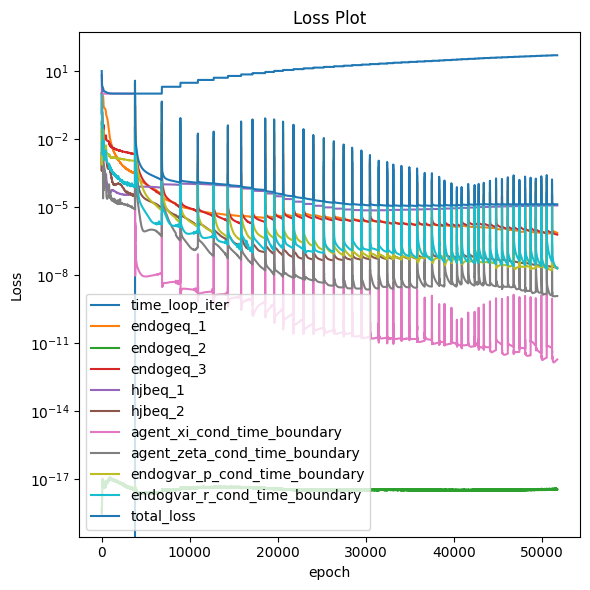

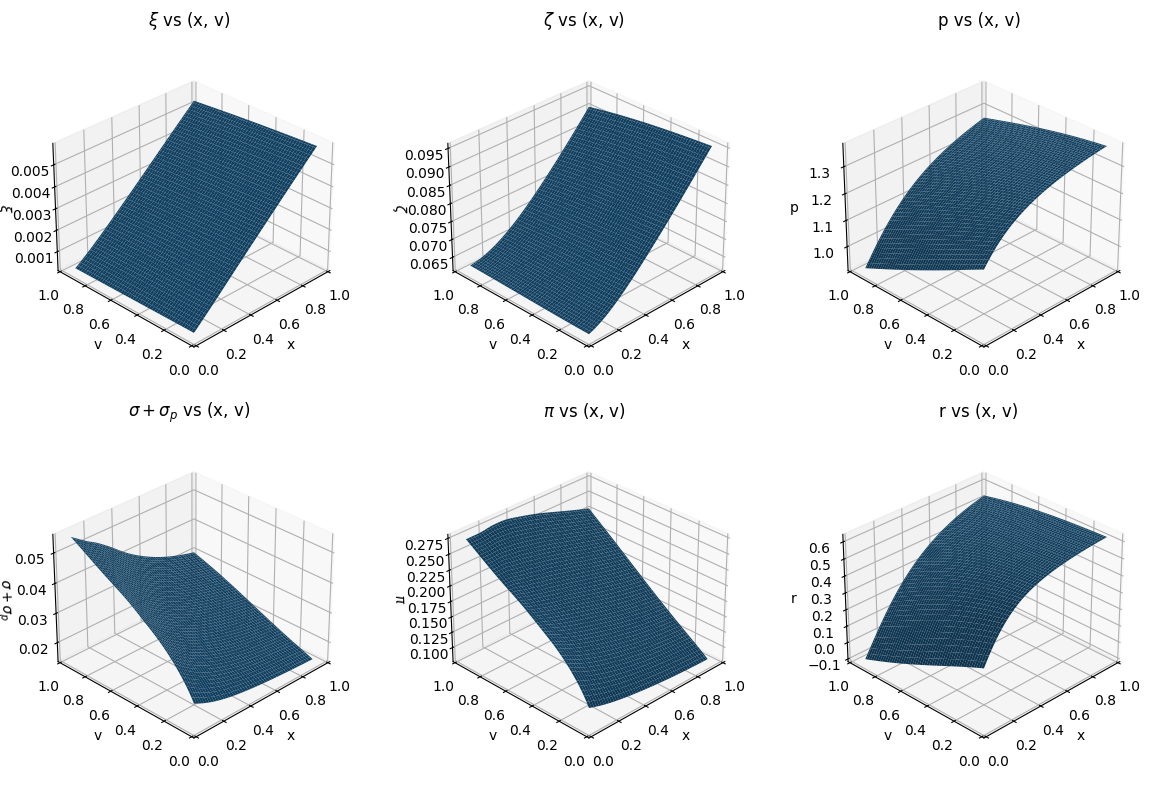

In [4]:
plot_loss_df(fn="./models/ditella/model_min_loss.csv", loss_plot_fn="./models/ditella/model_min_loss.png")
pde_model.plot_vars([r"$\xi$", r"$\zeta$", "p", 
                     r"$\sigma+\sigma_p = \sigma + \sigma_p$", r"$\pi$", "r"], ncols=3)

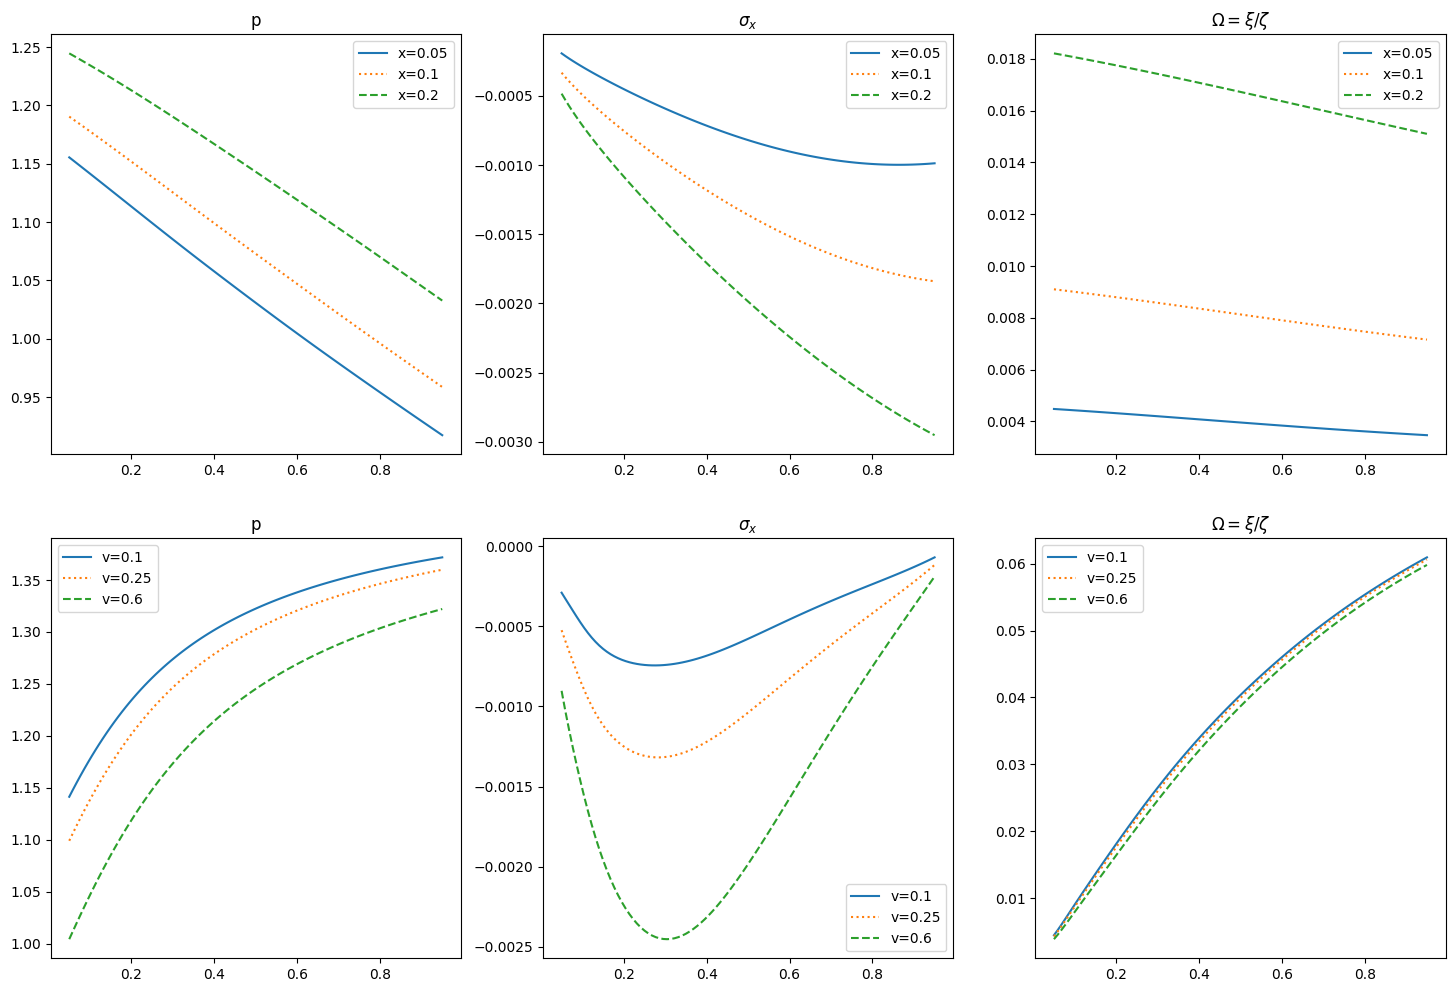

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for x_val, linestyle in [(0.05, "-"), (0.1, ":"), (0.2, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * x_val
    sv[:, 1] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    p = pde_model.variable_val_dict["p"]
    sigx = pde_model.variable_val_dict["sigx"]
    omega = pde_model.variable_val_dict["xi"] / pde_model.variable_val_dict["zeta"]
    ax[0][0].plot(sv[:, 1].detach().cpu().numpy(), p.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][1].plot(sv[:, 1].detach().cpu().numpy(), sigx.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][2].plot(sv[:, 1].detach().cpu().numpy(), omega.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][0].set_title(r"p")
    ax[0][1].set_title(r"$\sigma_x$")
    ax[0][2].set_title(r"$\Omega = \xi/\zeta$")
    ax[0][0].legend()
    ax[0][1].legend()
    ax[0][2].legend()

for v_val, linestyle in [(0.1, "-"), (0.25, ":"), (0.6, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * v_val
    sv[:, 0] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    p = pde_model.variable_val_dict["p"]
    sigx = pde_model.variable_val_dict["sigx"]
    omega = pde_model.variable_val_dict["xi"] / pde_model.variable_val_dict["zeta"]
    ax[1][0].plot(sv[:, 0].detach().cpu().numpy(), p.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][1].plot(sv[:, 0].detach().cpu().numpy(), sigx.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][2].plot(sv[:, 0].detach().cpu().numpy(), omega.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][0].set_title(r"p")
    ax[1][1].set_title(r"$\sigma_x$")
    ax[1][2].set_title(r"$\Omega = \xi/\zeta$")
    ax[1][0].legend()
    ax[1][1].legend()
    ax[1][2].legend()

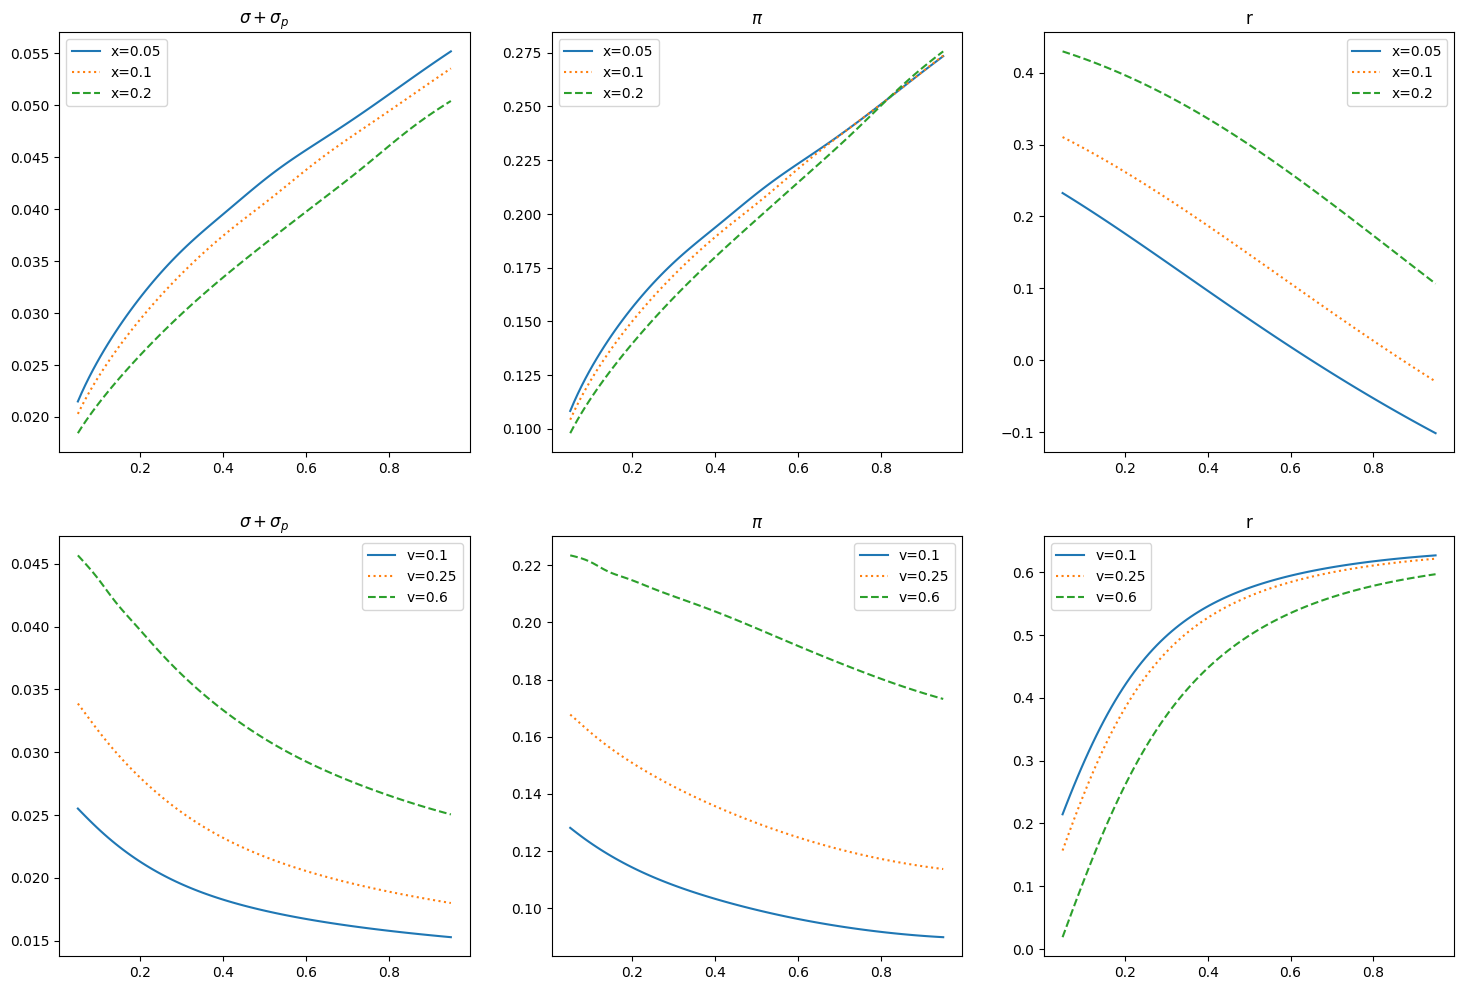

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for x_val, linestyle in [(0.05, "-"), (0.1, ":"), (0.2, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * x_val
    sv[:, 1] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    sigsigp = pde_model.variable_val_dict["sigma"] + pde_model.variable_val_dict["sigp"]
    pi = pde_model.variable_val_dict["signxi"]
    r = pde_model.variable_val_dict["r"]
    ax[0][0].plot(sv[:, 1].detach().cpu().numpy(), sigsigp.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][1].plot(sv[:, 1].detach().cpu().numpy(), pi.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][2].plot(sv[:, 1].detach().cpu().numpy(), r.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][0].set_title(r"$\sigma+\sigma_p$")
    ax[0][1].set_title(r"$\pi$")
    ax[0][2].set_title("r")
    ax[0][0].legend()
    ax[0][1].legend()
    ax[0][2].legend()
for v_val, linestyle in [(0.1, "-"), (0.25, ":"), (0.6, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * v_val
    sv[:, 0] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    sigsigp = pde_model.variable_val_dict["sigma"] + pde_model.variable_val_dict["sigp"]
    pi = pde_model.variable_val_dict["signxi"]
    r = pde_model.variable_val_dict["r"]
    ax[1][0].plot(sv[:, 0].detach().cpu().numpy(), sigsigp.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][1].plot(sv[:, 0].detach().cpu().numpy(), pi.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][2].plot(sv[:, 0].detach().cpu().numpy(), r.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][0].set_title(r"$\sigma+\sigma_p$")
    ax[1][1].set_title(r"$\pi$")
    ax[1][2].set_title("r")
    ax[1][0].legend()
    ax[1][1].legend()
    ax[1][2].legend()